In [1]:
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from functools import partial
%matplotlib inline

/home/tomek/.virtualenvs/ib/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


In [2]:
contract = pd.read_pickle('data/minute_ES_cont_non_active_included.pickle')
multiplier = 50
min_tick = 0.25

In [3]:
periods = [5, 10, 20, 40, 80] #, 160, 320] # 320] # number of periods for breakout rule
ema_fast = 120 # number of periods for moving average filter
sl_atr = 1 # stop loss in ATRs
atr_periods = 80 # number of periods to calculate ATR on
time_int = 15 # interval in minutes to be used to define volume candle

In [4]:
avg_vol = contract.loc['20190621':].volume.rolling(time_int).sum().mean()
avg_vol

15894.085711955635

In [5]:
#vol_candles = group_by_time(contract, time_int)
vol_candles = group_by_volume(contract, avg_vol)
data = pd.DataFrame(vol_candles.close)
data['ema_fast'] = data.close.ewm(span=ema_fast).mean()

In [6]:
def get_ATR(data, periods):
    TR = pd.DataFrame({'A': (data['high'] - data['low']),
                       'B': (data['high'] - data['close']).abs(),
                       'C': (data['low'] - data['close']).abs()
                      })
    TR['TR'] = TR.max(axis=1)
    TR['ATR'] = TR['TR'].rolling(periods).mean()
    return TR.ATR

In [7]:
def get_min_max(data, period):
    return pd.DataFrame({
        'max': (data - data.shift(1).rolling(period).max()) > 0,
        'min': (data.shift(1).rolling(period).min() - data) > 0
    })

def majority_function(data):
    return (0.5 + ((data.sum(axis=1) - 0.5) / data.count(axis=1))).apply(np.floor)

def get_min_max_df(data, periods, func=get_min_max):
    min_max_func = partial(func, data)
    mins = pd.DataFrame()
    maxs = pd.DataFrame()
    for period in periods:
        df = min_max_func(period)
        mins[period] = df['min']
        maxs[period] = df['max']
    return {'min': mins,
           'max': maxs}

def get_signals(data, periods, func=get_min_max_df):
    min_max = func(data, periods)
    #return min_max['min']
    
    return pd.DataFrame({
        'signal': majority_function(min_max['max']) - majority_function(min_max['min'])
    })
  

In [8]:
signals = pd.DataFrame({
    'close': data.close,
    'signal': get_signals(data.close, periods)['signal']
})

In [9]:
signals['value'] = signals['close'] * signals['signal']
signals['value'] = signals.value.map(lambda x: x if x != 0 else np.nan)
signals['buy'] = signals['value'].map(lambda x: x if x > 0 else np.nan)
signals['sell'] = signals['value'].map(lambda x: -x if x < 0 else np.nan)
signals['cum_signal'] = signals.signal.expanding().apply(lambda x: x.sum().clip(min=-1, max=1), raw=False)

In [10]:
signals['filter'] = np.sign(data.close - data.ema_fast)
signals['atr'] = get_ATR(vol_candles, atr_periods)

In [11]:
number_of_trades = 0
entry = 0
for row in signals.itertuples():
    if row.Index == 0:
        continue
    # if there's no position signal is to be filtered
    if signals.loc[row.Index-1, 'cum_signal'] == 0 and row.filter * row.signal != 1:
        signals.loc[row.Index, 'cum_signal'] = 0
        continue
    else:
        signals.loc[row.Index, 'cum_signal'] = (signals.loc[row.Index-1, 'cum_signal'] + row.signal).clip(max=1, min=-1)
        
    # create stop loss
    if signals.loc[row.Index, 'cum_signal'] - signals.loc[row.Index-1, 'cum_signal'] != 0:
        sl = signals.loc[row.Index, 'close'] - signals.loc[row.Index, 'cum_signal'] * signals.loc[row.Index, 'atr'] * sl_atr
        signals.loc[row.Index, 'sl'] = sl
    if not signals.loc[row.Index, 'sl']:
        signals.loc[row.Index, 'sl'] = signals.loc[row.Index-1, 'sl']
        
    # apply stop loss
    if signals.loc[row.Index, 'cum_signal'] == 1 and signals.loc[row.Index, 'close'] < sl:
        signals.loc[row.Index, 'cum_signal'] = 0
    elif signals.loc[row.Index, 'cum_signal'] == -1 and signals.loc[row.Index, 'close'] > sl:
        signals.loc[row.Index, 'cum_signal'] = 0
        
    # count trades
    if signals.loc[row.Index, 'cum_signal'] != signals.loc[row.Index-1, 'cum_signal']:
        number_of_trades += 1

In [12]:
signals['value'] = signals['close'] * signals['cum_signal']
signals['value'] = signals.value.map(lambda x: x if x != 0 else np.nan)
signals['long'] = signals['value'].map(lambda x: x if x > 0 else np.nan)
signals['short'] = signals['value'].map(lambda x: -x if x < 0 else np.nan)
signals['long_pnl'] = signals.long.diff().fillna(0)
signals['short_pnl'] = - signals.short.diff().fillna(0)

In [13]:
long_pnl = signals.long_pnl.sum()
short_pnl = signals.short_pnl.sum()
pnl = long_pnl + short_pnl
long_pnl, short_pnl, pnl

(3372.0, 2632.75, 6004.75)

In [14]:
signals['pnl'] = signals['long_pnl'] + signals['short_pnl']
pnl_p = signals[signals['pnl']>0].pnl
pnl_m = signals[signals['pnl']<0].pnl
pnl_p.count(), pnl_m.count(), pnl_p.count()/(pnl_p.count()+pnl_m.count())

(16821, 14464, 0.5376698098130094)

In [15]:
pnl_p.sum(), pnl_m.sum(), pnl_p.sum()/ pnl_m.abs().sum()

(30366.25, -24361.5, 1.24648523284691)

In [16]:
pnl_m.sort_values().head(20)

label
12805   -25.75
12911   -21.25
49861   -19.50
12880   -16.50
47563   -16.00
49851   -16.00
12898   -15.75
13502   -13.75
13331   -13.50
12910   -13.00
12947   -13.00
12933   -13.00
22407   -12.75
14970   -12.50
9501    -12.50
28037   -12.25
12871   -12.00
34581   -11.75
33502   -11.50
29831   -11.25
Name: pnl, dtype: float64

In [17]:
pnl_p.sort_values(ascending=False).head(20)

label
32566    35.00
12894    21.00
46071    19.75
13995    17.75
35044    17.50
9597     17.25
12896    17.00
35157    16.75
12802    16.25
50318    16.00
48116    15.75
34493    15.75
9500     15.50
12900    15.50
48815    15.50
12892    14.50
12866    13.25
13767    12.75
44414    12.50
12638    12.50
Name: pnl, dtype: float64

In [18]:
signals['date'] = vol_candles['date']

In [19]:
signals.set_index('date', inplace=True)

In [20]:
daily = pd.DataFrame()
daily['close'] = signals['close'].resample('D').last()
daily['pnl'] = (signals['long_pnl'] + signals['short_pnl']).resample('D').sum()
daily.tail()

,close,pnl
date,,
2019-09-01,NaN,0.00
2019-09-02,2903.00,1.25
2019-09-03,2903.75,-9.50
2019-09-04,2938.25,19.75
2019-09-05,2958.00,19.75


In [21]:
daily.head()

,close,pnl
date,,
2017-03-28,2331.5,0.0
2017-03-29,NaN,0.0
2017-03-30,NaN,0.0
2017-03-31,NaN,0.0
2017-04-01,NaN,0.0


In [22]:
daily['dollars'] = 0
daily.iloc[0,2] = 15000

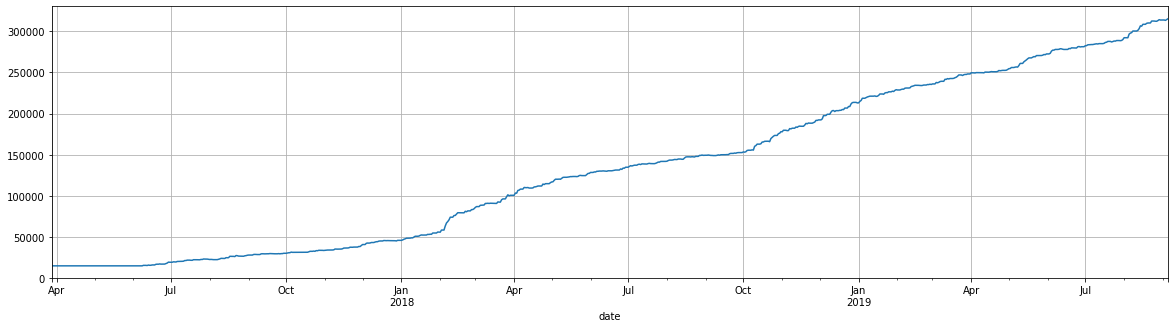

In [23]:
daily['dollars'] = 15000 + daily.pnl.cumsum() * multiplier
daily['return'] = daily.dollars.pct_change()
daily.dollars.plot(figsize=(20,5), grid=True);

In [24]:
daily['absolute'] = daily['pnl'] * multiplier/10000

In [25]:
perf_stats(daily['absolute'].iloc[40:])

Annual return          3.543851e+03
Cumulative returns     1.002355e+12
Annual volatility      1.141718e+00
Sharpe ratio           7.777985e+00
Calmar ratio           2.892940e+04
Stability              9.835183e-01
Max drawdown          -1.225000e-01
Omega ratio            9.788511e+00
Sortino ratio          4.540752e+01
Skew                   2.332461e+00
Kurtosis               7.465417e+00
Tail ratio             6.801865e+00
Daily value at risk   -1.086038e-01
dtype: float64

In [26]:
perf_stats(daily['return'].iloc[40:])

Annual return           1.461364
Cumulative returns     20.015833
Annual volatility       0.144858
Sharpe ratio            6.299726
Calmar ratio           43.958757
Stability               0.933246
Max drawdown           -0.033244
Omega ratio             8.226584
Sortino ratio          32.882328
Skew                    3.332255
Kurtosis               16.364858
Tail ratio              7.656937
Daily value at risk    -0.014629
dtype: float64

In [27]:
number_of_trades

3279

In [28]:
spread = min_tick * multiplier
commission = 1.18 + .85 
cost_of_trades = number_of_trades * (spread + commission)
cost_of_trades

47643.869999999995

In [29]:
days = (daily.index[-1] - daily.index[0]).days #pd.to_datetime('20190613')).days
days

891

In [30]:
trades_per_day = number_of_trades / days
trades_per_day

3.68013468013468

In [31]:
pnl_in_dollars = pnl*multiplier

In [32]:
cost_of_trades / (pnl_in_dollars)

0.15868727257587742

In [33]:
mean = daily['return'].mean() * 252
std = daily['return'].std() * (252**.5)
mean, std

(0.8726219127848995, 0.14213657120857576)

In [34]:
mean/std

6.139320129682783

In [35]:
#daily.to_pickle('nq_return.pickle')